In [1]:
import numpy as np
import matplotlib.pyplot as plt
import access_spectrum as acs
from empca_residuals import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/setuptools-18.7.1-py2.7.egg/pkg_resources/__init__.py:1266: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).


In [2]:
import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  20 # Tune this according to personal preference
}

matplotlib.rc('font',**font)

default_cmap = 'plasma'
colours = plt.get_cmap('plasma')(np.linspace(0,0.80,4))

In [21]:
def consth(n,model,N,D):
    hs = np.ones(n)
    hs = np.sqrt((1./len(model.weights[model.weights!=0]))*np.sum(1./model.weights[model.weights!=0]))*hs
    return hs               

def calculate_Ncells(model,N=None,D=None,denom=None,denomfunc=consth):
    """
    model:      EMPCA model object that contains eigenvalues
    N:          Number of measurements in the data set (i.e. number of stars)
    D:          Number of dimensions in each measurement (i.e. pixels)
    denom:      If None, compute denominator(s) with denomfunc. Else uses denominators as set.
    denomfunc:  A function used to compute the denominator(s). Assumes the same uncertainty across the entire data set by default
    
    """
    numeig = len(model.eigval)
    if not N or not D:
        D = model.data.shape[1]
        N = model.data.shape[0]
    if denom:
        try:
            denom = denom*np.ones(numeig) # Tile out the denominator values into an array
        except ValueError as e:
            print 'Input denominator array has invalid shape, should be {0}'.format(len(model.eigval))
            print e
            return None
    elif not denom:
        denom = denomfunc(numeig,model,N,D)
    #print denom
    def calcNcells(n,denom,D,N):
        if D < N:
            return np.prod(np.sqrt(D*model.eigval[:n+1]))/np.prod(denom[:n+1])
        elif N < D:
            return np.prod(np.sqrt(N*model.eigval[:n+1]))/((D/N)*np.prod(denom[:n+1]))
    Ncells = np.zeros(numeig)
    for n in range(len(model.eigval)):
        Ncells[n] = calcNcells(n,denom,D,N)
    return Ncells,denom

def compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename1=None,
                   savename2=None,figsize=(15,6),tingpredict=True,denom=None,denomfunc=consth):
    plt.figure(1,figsize=figsize)
    plt.figure(2,figsize=figsize)
    for d in range(len(direcs)):
        plt.figure(1)
        plt.subplot(1,len(direcs),d+1)
        plt.ylim(0,1)
        plt.title(titles[d],fontsize=18)
        plt.xlabel('number of eigenvectors',fontsize=14)
        plt.figure(2)
        plt.subplot(1,len(direcs),d+1)
        plt.xlabel('number of eigenvectors',fontsize=14)
        if d==0:
            plt.figure(1)
            plt.ylabel(r'$R^2$',fontsize=18)
            plt.yticks(fontsize=13)
            plt.figure(2)
            plt.ylabel(r'$N_{\mathrm{cells}}$',fontsize=18)
            plt.yticks(fontsize=13)
        if d!=0:
            plt.figure(1)
            plt.yticks([])
            plt.figure(2)
            plt.yticks(fontsize=13)
        c = 0
        for m in range(len(models)):
            model = acs.pklread('{0}/{1}'.format(direcs[d],models[m]))
            plt.xlim(-1,len(model.R2Array))
            print '{0}/{1} R2noise {2}'.format(direcs[d],models[m],model.R2noise)
            Ncells = calculate_Ncells(model,denom=denom,denomfunc=denomfunc)[0]
            
            if m==0:
                if tingpredict:
                    plt.figure(1)
                    plt.axvline(4,color='k',lw=2)
                    plt.axvline(5,color='k',lw=2)
                    plt.fill_between(np.arange(4,6),0,1,alpha=0.25,color='k')
                    plt.text(5+0.03*len(model.R2Array),0.5,'Ting+ (2015)\n prediction',fontsize=13)
                    plt.figure(2)
                    plt.axvline(4,color='k',lw=2)
                    plt.axvline(5,color='k',lw=2)
                    plt.fill_between(np.arange(4,6),0,1,alpha=0.25,color='k')
                    if np.max(Ncells)>1e3:
                        plt.axhline(1e3,color='k',lw=2)
                    #plt.text(5+0.03*len(model.R2Array),******************,'Ting+ (2015)\n prediction',fontsize=13)
            crossvec = np.where(model.R2Array > model.R2noise)
            if crossvec[0] != []:
                crossvec = crossvec[0][0] - 1
                if crossvec < 0:
                    crossvec = 0
                plt.figure(1)
                plt.axvline(crossvec,0,model.R2Array[crossvec],color=colours[c],lw=2)
                plt.text(crossvec+0.03*len(model.R2Array),0.02,'{0}'.format(crossvec),
                         color=colours[c],weight='bold',fontsize=13)
            # Plot R2 curve
            plt.figure(1)
            if d==0 and m==0:
                plt.axhline(model.R2noise,color='k',ls='--',lw=3,label=r'$R^2_{noise}$')
            if d==len(direcs)-1:
                plt.plot(model.R2Array,color=colours[c],lw=4,label=labels[m])
            elif d!=len(direcs)-1:
                plt.plot(model.R2Array,color=colours[c],lw=4)
            plt.axhline(model.R2noise,color=colours[c],ls='--',lw=3)
            
             # Plot Ncells curve
            plt.figure(2)
            if d==len(direcs)-1:
                plt.semilogy(Ncells,'-',lw=4,color=colours[c],label=labels[m])
            if d!=len(direcs)-1:
                plt.semilogy(Ncells,'-',lw=4,color=colours[c])
            
            c+=1
            
        plt.figure(1)
        plt.xticks(np.linspace(0,len(model.R2Array),5,dtype=int)[:-1],fontsize=13)
        plt.figure(2)
        plt.xticks(np.linspace(0,len(model.R2Array),5,dtype=int)[:-1],fontsize=13)
        if d==len(direcs)-1:
            plt.figure(1)
            legend = plt.legend(loc='best',fontsize=13,title='$R^2$ calculation')
            legend.get_title().set_fontsize('16')
            legend.get_frame().set_linewidth(0.0)
            plt.figure(2)
            legend = plt.legend(loc='best',fontsize=13,title='$R^2$ calculation')
            legend.get_title().set_fontsize('16')
            legend.get_frame().set_linewidth(0.0)
        if d==0:
            plt.figure(1)
            legend = plt.legend(loc='best',fontsize=18)
            legend.get_frame().set_linewidth(0.0)
    plt.figure(1)
    plt.subplots_adjust(wspace=0)
    if savename1:
        plt.savefig(savename1)
    plt.figure(2)
    plt.subplots_adjust(wspace=0.5)
    if savename2:
        plt.savefig(savename2)

# Generate correction using NGC 6819 
#### Run the box below using the bolded responses to the prompts

Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **CLUSTER**  
Default is full range. Match or slice? **match**  
Match value: **N6819**  
Data key: **done**


In [3]:
oc = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)
oc.findResiduals(minStarNum=5,gen=True)
correction = oc.findCorrection(median=True,numpix=30.,savename='n6819_dr12_30px.pkl')

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: CLUSTER
Default is full range. Match or slice? m
Match value: N6819
Data key: done


Done getting filter information


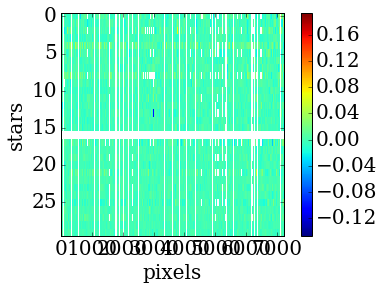

In [4]:
oc.imshow(oc.residuals)

7.4853611710769125e-05

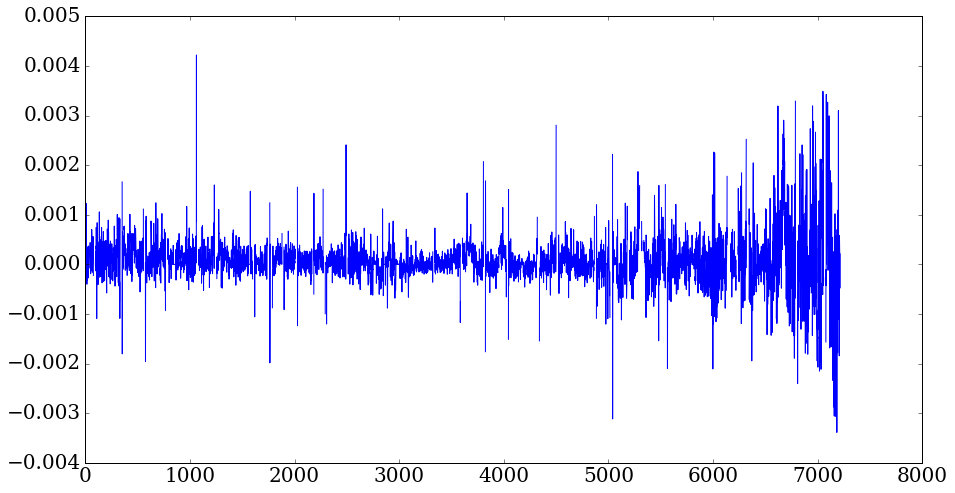

In [5]:
plt.figure(figsize=(15,8))
plt.plot(np.mean(oc.residuals,axis=0))
np.mean(oc.residuals)

In [6]:
oc.pixelEMPCA(nvecs=5,mad=True,savename='test.pkl')

       iter        R2             rchi2
EMPCA  1/25       0.02271412      2.15879209
EMPCA  2/25       0.32822612      1.21840780
EMPCA  3/25       0.37976408      1.12013061
EMPCA  4/25       0.39791334      1.08829660
EMPCA  5/25       0.41465062      1.06518467
EMPCA  6/25       0.42438543      1.05109097
EMPCA  7/25       0.42574048      1.04408298
EMPCA  8/25       0.42701424      1.04057906
EMPCA  9/25       0.42536833      1.03844116
EMPCA 10/25       0.42390483      1.03659533
EMPCA 11/25       0.42386001      1.03463591
EMPCA 12/25       0.42336209      1.03259139
EMPCA 13/25       0.42446044      1.03062774
EMPCA 14/25       0.42385166      1.02884964
EMPCA 15/25       0.42475204      1.02729005
EMPCA 16/25       0.42543536      1.02595586
EMPCA 17/25       0.42507842      1.02484455
EMPCA 18/25       0.42472525      1.02394348
EMPCA 19/25       0.42564855      1.02323023
EMPCA 20/25       0.42572764      1.02267666
EMPCA 21/25       0.42667282      1.02225368
EMPCA 22/25    

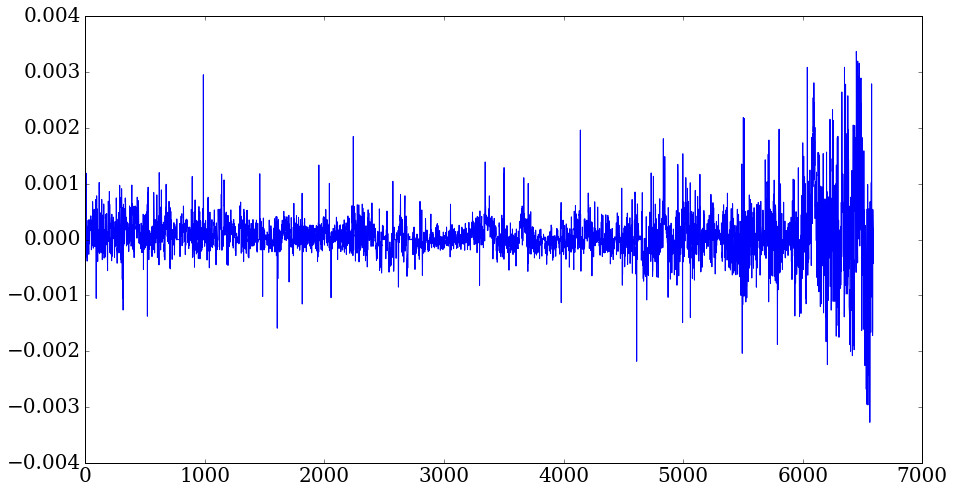

In [9]:
plt.figure(figsize=(15,8))
plt.plot(oc.empcaModelWeight.datamean)

In [10]:
np.mean(oc.empcaModelWeight.data,axis=0)

array([ 0.0322742 ,  0.0321813 ,  0.03231137, ...,  0.09791187,
        0.09785307,  0.09964494])

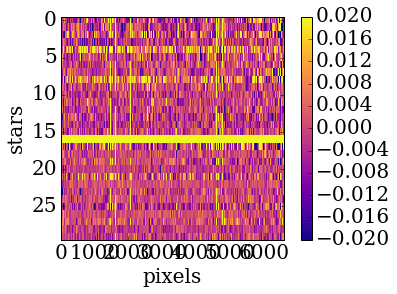

In [15]:
oc.imshow(oc.empcaModelWeight.data,vmin=-0.02,vmax=0.02,cmap='plasma')

# Figures

## Figure 1 - Red clump sample coverage

#### To generate data to create this plot, run the next box and fill in the prompts with the bolded responses
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): *press Enter*  
Lower limit (Enter for minimum): *press Enter*   
Found good limits
Data key: **done**
#### Note that this part can take a few minutes on an initial run, but once data is stored it can be recalled in about thirty seconds

In [6]:
rc = empca_residuals('apogee','red_clump',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 
Lower limit (Enter for minimum): 
Found good limits
Data key: done
Done getting filter information


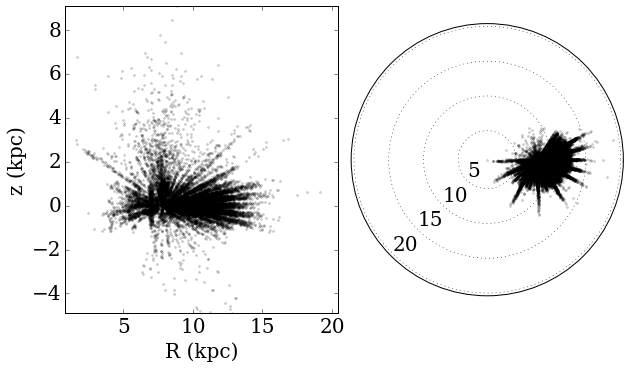

In [7]:
rc.show_sample_coverage()

## Figure 2 - Hertzsprung-Russell Diagrams

#### To generate data for this plot, first run the data generation box for figure 1 above to create the rc object. Then run the box below and fill in the prompts with the bolded responses
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): *press Enter*  
Lower limit (Enter for minimum): *press Enter*  
Found good limits  
Data key: **done**
#### Note that this part can take a few minutes on an initial run, but once data is stored it can be recalled in about thirty seconds

In [8]:
rg = empca_residuals('apogee','red_giant',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 
Lower limit (Enter for minimum): 
Found good limits
Data key: done
Done getting filter information


In [9]:
def hist2d(fig,ax,x,y,bins=100,clabel=False,vmin=0,vmax=110):
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H==0,H)
    im = ax.pcolormesh(xedges,yedges,Hmasked,
                   cmap = plt.get_cmap(default_cmap),
                   vmin=vmin,vmax=vmax)
    if clabel:
        cbar=fig.colorbar(im,pad = -0.05)
        cbar.set_label(label=clabel,fontsize=20)
        cbar.ax.tick_params(labelsize=20)
    elif not clabel:
        cbar=fig.colorbar(im,pad = -0.05)
        cbar.ax.tick_params(labelsize=20)

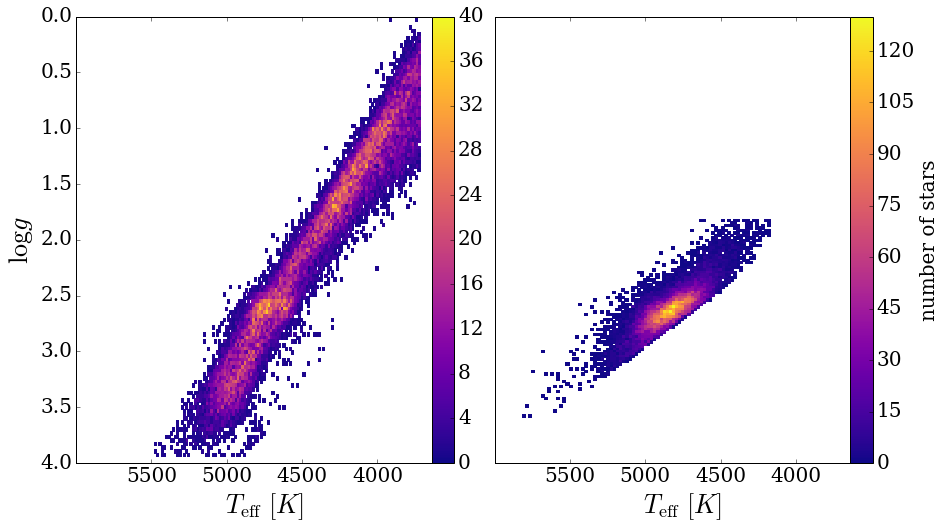

In [10]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
hist2d(fig,ax,rg.teff,rg.logg,bins=120,vmax=40)
plt.ylim(4,0)
plt.xlim(6000,3500)
plt.xticks(np.arange(4000,6000,500)[::-1],fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\log g$',fontsize=26)
plt.xlabel(r'$T_{\mathrm{eff}}\,\,[K]$',fontsize=26)
#plt.axhline(2,color='r',ls='--',lw=2)
#plt.axhline(3,color='r',ls='--',lw=2)
#plt.axhline(4,color='r',ls='--',lw=2)
#plt.fill_between(np.arange(3500,6100,100),4,2,alpha=0.1,color='r')
#plt.axvline(4700,color='k',ls='--',lw=2)
#plt.axvline(4900,color='k',ls='--',lw=2)
#plt.fill_between(np.arange(4700,5000,100),4,0,alpha=0.1,color='k')
#plt.title('red giant stars')
ax = fig.add_subplot(122)
hist2d(fig,ax,rc.teff,rc.logg,clabel='number of stars',bins=80,vmax=130)
plt.ylim(4,0)
plt.xlim(6000,3500)
plt.xticks(np.arange(4000,6000,500)[::-1],fontsize=20)
plt.yticks([])
plt.xlabel(r'$T_{\mathrm{eff}}\,\,[K]$',fontsize=26)
#plt.title('red clump stars')
#plt.axvline(4700,color='k',ls='--',lw=2)
#plt.axvline(4800,color='k',ls='--',lw=2)
#plt.axvline(4900,color='k',ls='--',lw=2)
#plt.axvline(5000,color='k',ls='--',lw=2)
#plt.axvline(5100,color='k',ls='--',lw=2)
#plt.fill_between(np.arange(4700,5200,100),4,0,alpha=0.1,color='k')
plt.subplots_adjust(wspace=0)
plt.savefig('HRdiagram.pdf')

## Figure 3 - Example polynomial fit for NGC 6819 in Teff

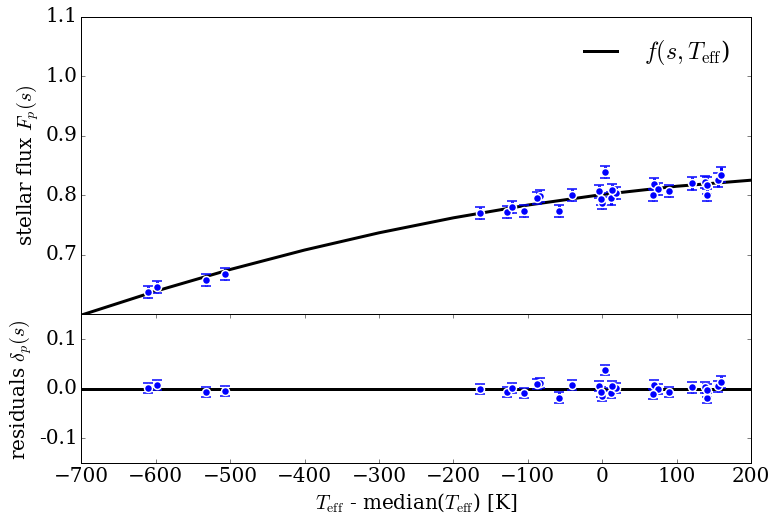

In [11]:
oc.correctUncertainty(correction='n6819_dr12_30px.pkl')
oc.plot_example_fit(indep=1,pixel=4313,xlabel='$T_{\mathrm{eff}}$ - median($T_{\mathrm{eff}}$) [K]')
oc.uncorrectUncertainty(correction='n6819_dr12_30px.pkl')
plt.savefig('Open_cluster_corrected.pdf')

## Figure 4 - Comparing EMPCA model with data

In [9]:
subrc = empca_residuals('apogee','red_clump',maskFilter,ask=True,degree=2)
subrc.findResiduals(gen=False)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 4900
Lower limit (Enter for minimum): 4800
Found good limits
Data key: done
Done getting filter information


In [34]:
subrcmodel = acs.pklread('red_clump_12_TEFF_up4900.0_lo4800.0/eig500_minSNR50_corrNone_madTrue.pkl')
totalapprox = np.zeros(subrc.residuals.shape)
nvec = 10
for i in range(nvec):
    totalapprox += np.outer(subrcmodel.coeff[:, i], subrcmodel.eigvec[i])

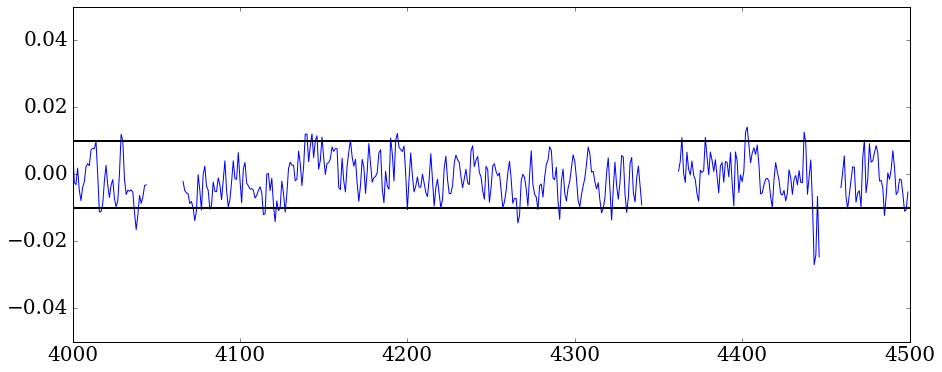

In [38]:
indx = 905
pixup = 4500
pixdown = 4000
plt.figure(figsize=(15,6))
plt.plot(np.arange(pixdown,pixup),subrc.residuals[indx][pixdown:pixup]-totalapprox[indx][pixdown:pixup],lw=1)
plt.xlim(pixdown,pixup)
plt.ylim(-0.05,0.05)
plt.axhline(0.01,color='k',lw=2)
plt.axhline(-0.01,color='k',lw=2)
plt.savefig('modelsub.pdf')

## Figure 5 - R2 for NGC6819 using variance and MAD

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:85: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



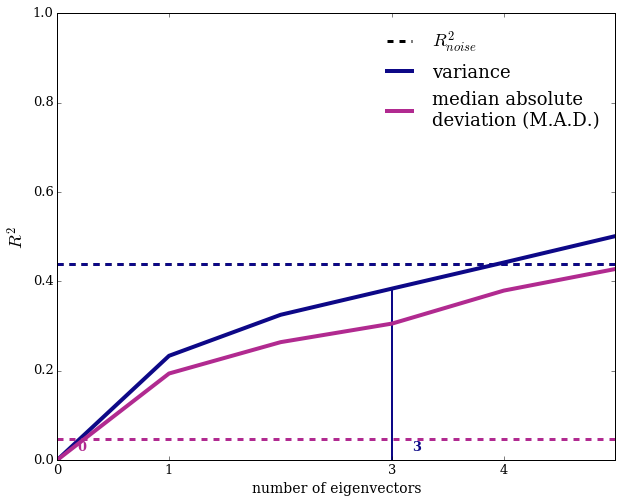

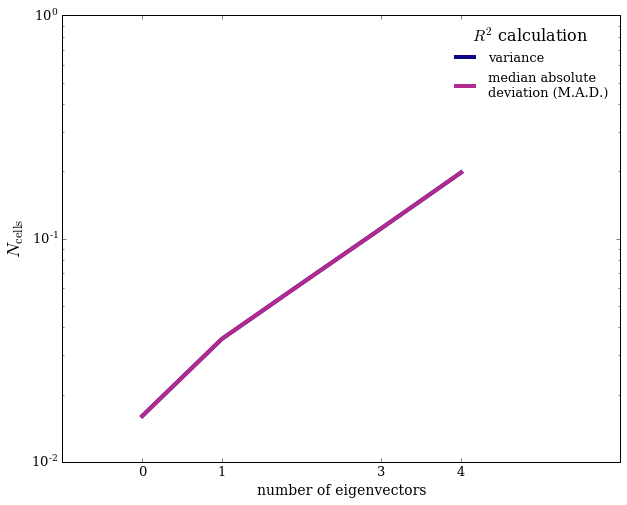

In [76]:
direcs = ['clusters_12_CLUSTER_matchN6819']
titles = ['']
models = ['eig5_minSNR50_corrNone_madFalse.pkl',
          'eig5_minSNR50_corrNone_madTrue.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename1='n6819_R2comparison.pdf',savename2='n6819_Ncellscomparison.pdf',figsize=(10,8),tingpredict=False)

## Figure 6 - Ncells for NGC 6819

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:85: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



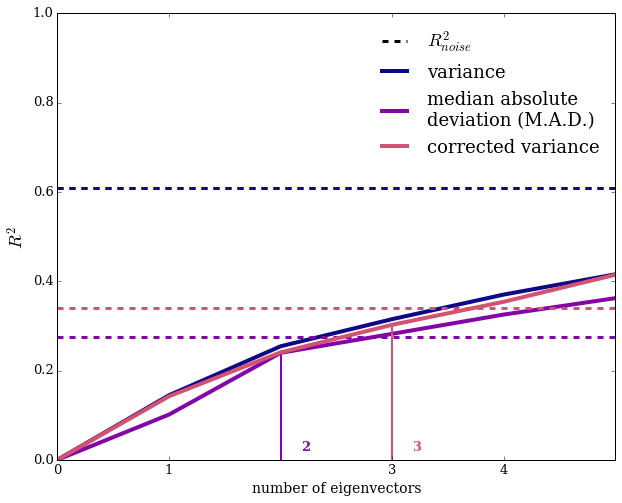

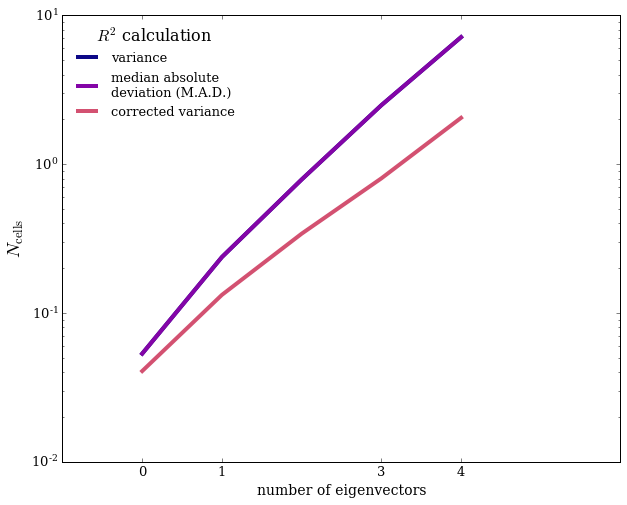

In [19]:
direcs = ['clusters_12_CLUSTER_matchM13']
titles = ['']
models = ['eig5_minSNR50_corrNone_madFalse.pkl',
          'eig5_minSNR50_corrNone_madTrue.pkl',
          'eig5_minSNR50_corr30px_madFalse.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)','corrected variance']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename1='m13_comparison.pdf',figsize=(10,8),tingpredict=False)

## Figure 7 - Covariance matrix for NGC 6819

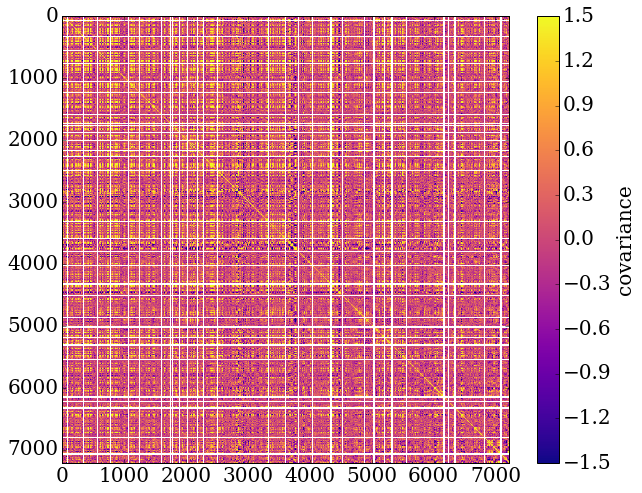

In [13]:
plt.figure(figsize=(10,8))
oc.imshow(oc.cov,xlabel='',ylabel='',zlabel='covariance',vmax=1.5,vmin=-1.5,cmap='plasma')
plt.savefig('n6819_dr12_cov.pdf')

## Figure 8 - Correction factor from NGC 6819

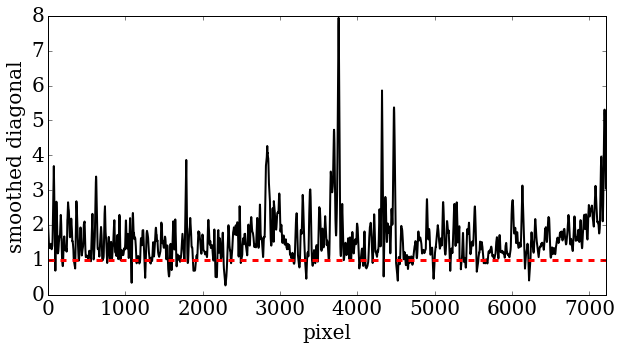

In [14]:
plt.figure(figsize=(10,5))
plt.plot(correction,color='k',lw=2)
plt.axhline(1,color='r',lw=3,ls='--')
plt.xlabel('pixel')
plt.ylabel('smoothed diagonal')
plt.xlim(0,7214)
plt.savefig('n6819_dr12_correction.pdf')

## Figure 9 - Open cluster R2 comparison

clusters_12_CLUSTER_matchN6819/eig5_minSNR50_corrNone_madFalse.pkl R2noise 0.436594515233
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.

clusters_12_CLUSTER_matchN6819/eig5_minSNR50_corrNone_madTrue.pkl R2noise 0.0559017748307
clusters_12_CLUSTER_matchN6819/eig5_minSNR50_corr30px_madFalse.pkl R2noise 0.0603038696755
clusters_12_CLUSTER_matchN2158/eig5_minSNR50_corrNone_madFalse.pkl R2noise 0.467248096374
clusters_12_CLUSTER_matchN2158/eig5_minSNR50_corrNone_madTrue.pkl R2noise 0.0257727322095
clusters_12_CLUSTER_matchN2158/eig5_minSNR50_corr30px_madFalse.pkl R2noise 0.0806625921252
clusters_12_CLUSTER_matchM67/eig5_minSNR50_corrNone_madFalse.pkl R2noise 0.292249307238
clusters_12_CLUSTER_matchM67/eig5_minSNR50_corrNone_madTrue.pkl R2noise -0.0685569960432
clusters_12_CLUSTER_matchM67/eig5_minSNR50_corr30px_madFalse.pkl R2noise -0.146184783826


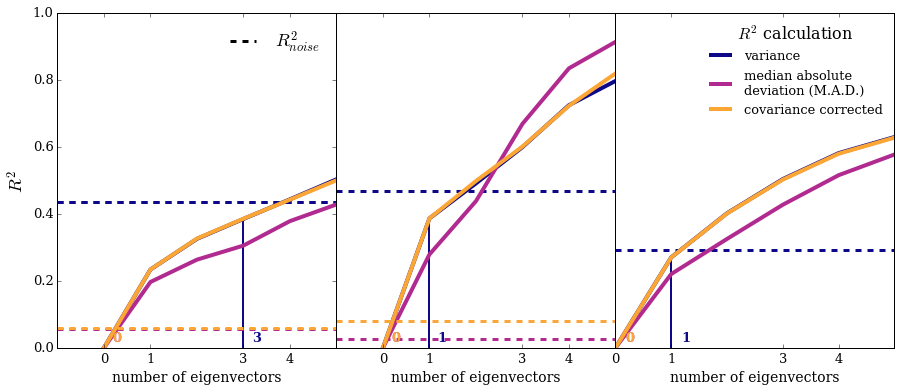

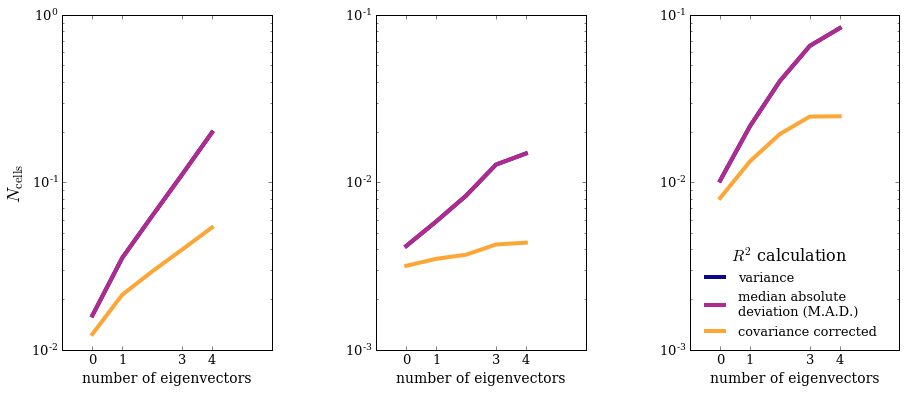

In [22]:
direcs = ['clusters_12_CLUSTER_matchN6819',
          'clusters_12_CLUSTER_matchN2158',
          'clusters_12_CLUSTER_matchM67']
titles = ['',
          '',
          '']
models = ['eig5_minSNR50_corrNone_madFalse.pkl',
          'eig5_minSNR50_corrNone_madTrue.pkl',
          'eig5_minSNR50_corr30px_madFalse.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)','covariance corrected']
colours = plt.get_cmap('plasma')(np.linspace(0,0.80,len(models)))
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename1='DR12_oc_comparison.pdf',tingpredict=False)

## Figure 10 - Open cluster Ncells comparison

## Figure 11 - R2 for red clump sample with a large number of eigenvectors

#### To create the data for this figure, run the following in the same directory as this notebook

python run_all_empca.py

#### Then fill out the prompts with the bolded responses

Which sample: red clump, red giant or cluster? **red clump**  
How many eigenvectors in the model (Enter for 60): **500**  
What's the minimum signal to noise? (Enter for 50): *press Enter*   
Shall I get data from scratch? (Enter for yes): **no**  
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **4900**  
Lower limit (Enter for minimum): **4800**  
Found good limits  
Data key: **done** 

#### This will take about a day to complete, so run it in the background. Once it's done, run the box below

AttributeError: 'smallEMPCA' object has no attribute 'eigval'

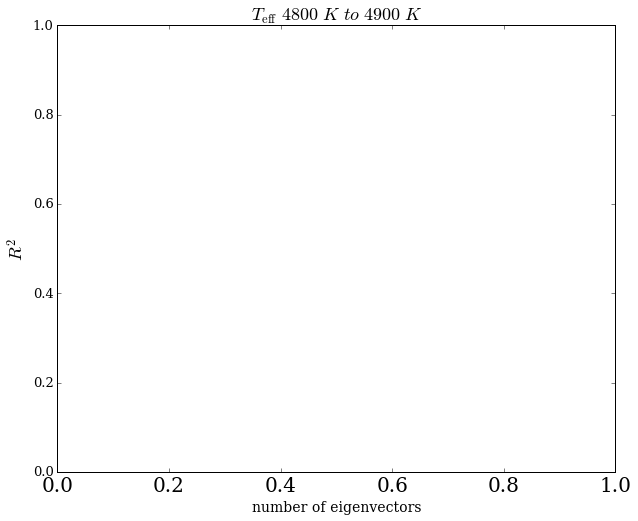

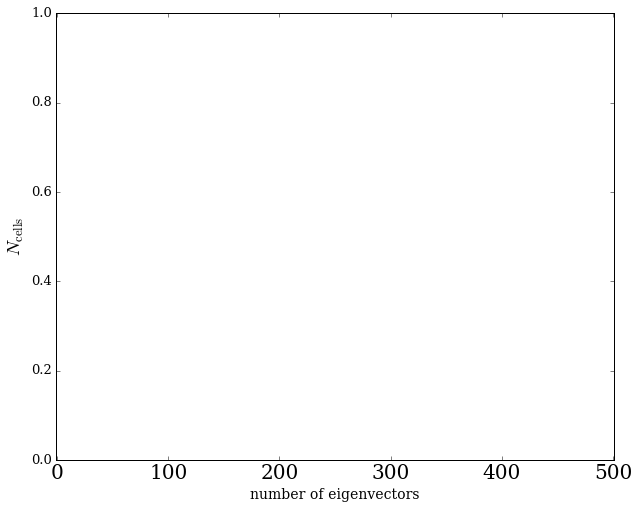

In [63]:
direcs = ['red_clump_12_TEFF_up4900.0_lo4800.0']
titles = [r'$T_{\mathrm{eff}}\,\,4800\,\,K\,\,to\,\,4900\,\,K$']
models = ['eig500_minSNR50_corrNone_madFalse.pkl',
          'eig500_minSNR50_corrNone_madTrue.pkl',
          'eig500_minSNR50_corr30px_madFalse.pkl']
labels =  ['covariance','median absolute\ndeviation (M.A.D.)','covariance corrected']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename1='mammoth_R2.pdf',savename2='mammoth_Ncells.pdf',figsize=(10,8))

## Figure 12 - R2 for red clump 100K slice subsample comparison

#### To create the data for this figure, run the following in the same directory as this notebook

python run_all_empca.py

#### Then fill out the prompts with the bolded responses

Which sample: red clump, red giant or cluster? **red clump**  
How many eigenvectors in the model (Enter for 60): *press Enter*  
What's the minimum signal to noise? (Enter for 50): *press Enter*   
Shall I get data from scratch? (Enter for yes): **no**  
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **4900**  
Lower limit (Enter for minimum): **4800**  
Found good limits 
Data key: **done** 

#### Then repeat this script twice more, with all prompts the same except for the limits. The other two runs should have 

Upper limit (Enter for maximum): **4800**  
Lower limit (Enter for minimum): **4700**  

#### and 

Upper limit (Enter for maximum): **4900**  
Lower limit (Enter for minimum): **4700**  

#### respectively

#### This will take about four hours to complete for each run, so run in parallel if possible. Once it's done, run the box below

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:92: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



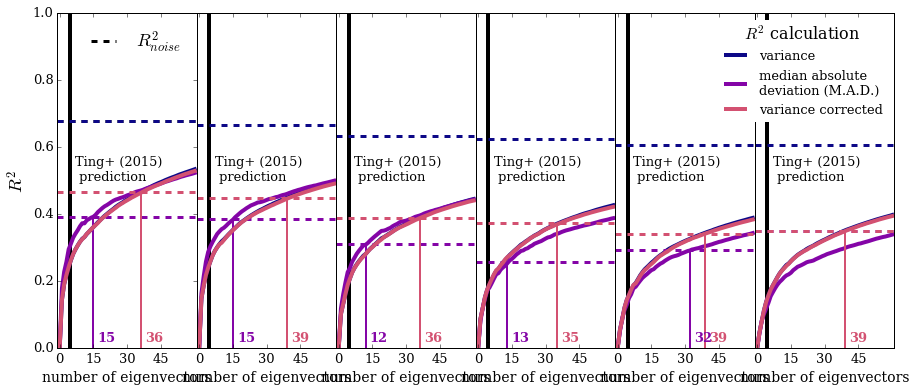

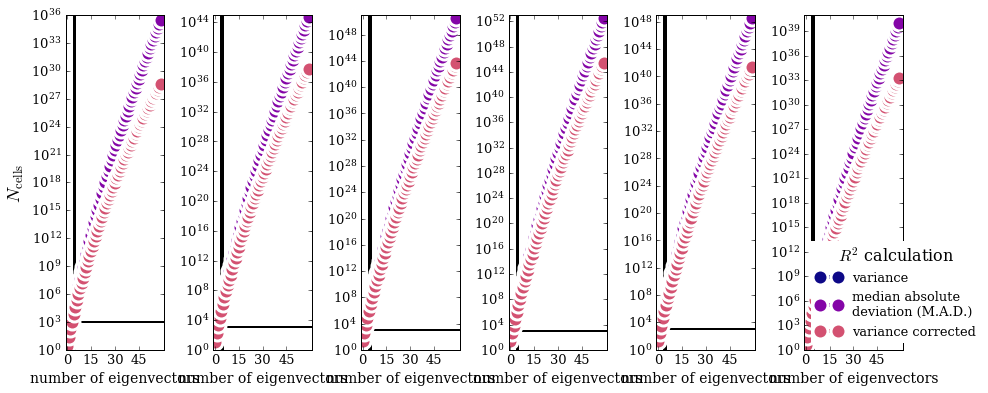

In [68]:
direcs = [#'red_clump_12_TEFF_up4900.0_lo4700.0',
          'red_clump_12_TEFF_up4600.0_lo4500.0',
          'red_clump_12_TEFF_up4700.0_lo4600.0',
          'red_clump_12_TEFF_up4800.0_lo4700.0',
          'red_clump_12_TEFF_up4900.0_lo4800.0',
          'red_clump_12_TEFF_up5000.0_lo4900.0',
          'red_clump_12_TEFF_up5100.0_lo5000.0']
titles = [#'red_clump_12_TEFF_up4900.0_lo4700.0',
          '',
          '',
          '',
          '',
          '',
          '']
models = ['eig60_minSNR50_corrNone_madFalse.pkl',
          'eig60_minSNR50_corrNone_madTrue.pkl',
          'eig60_minSNR50_corr30px_madFalse.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)','variance corrected']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename1='RC_DR12_comparison.pdf',figsize=(15,6))

[ 0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603
  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603  0.00618603]
[  3.03405946e+00   3.69204979e+01   3.40551530e+02   2.94385262e+03
   2.37939064e+04   1.80693273e+05   1.17438968e+06   7.16403656e+06
   4.18185348e+07   2.23812676e+08   9.02543674e+08   4.75187516e+09
   2.22213470e+10   1.06669060e+11   4.94862328e+11   2.354787

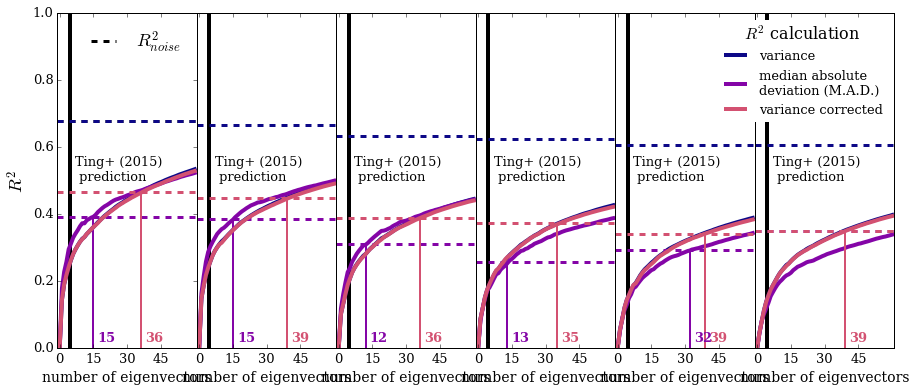

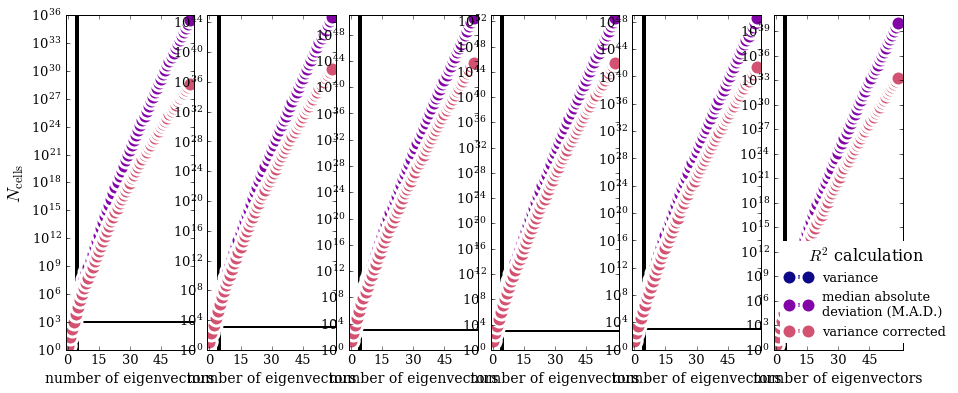

In [66]:
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename1='RC_DR12_comparison.pdf',figsize=(15,6))

## R2 for red clump with 50K slices

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



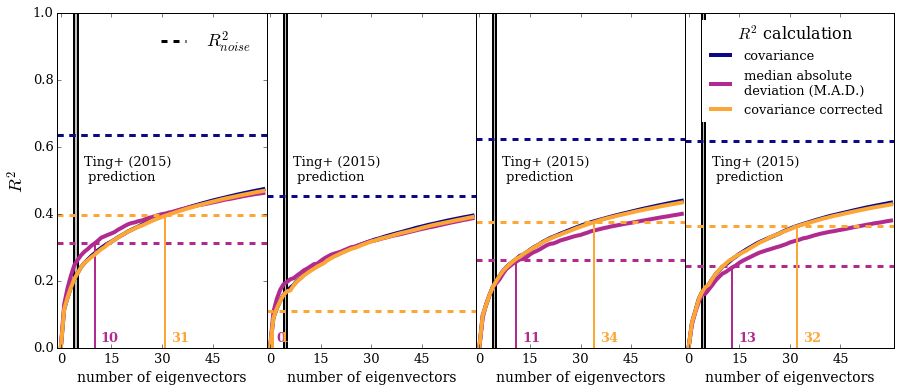

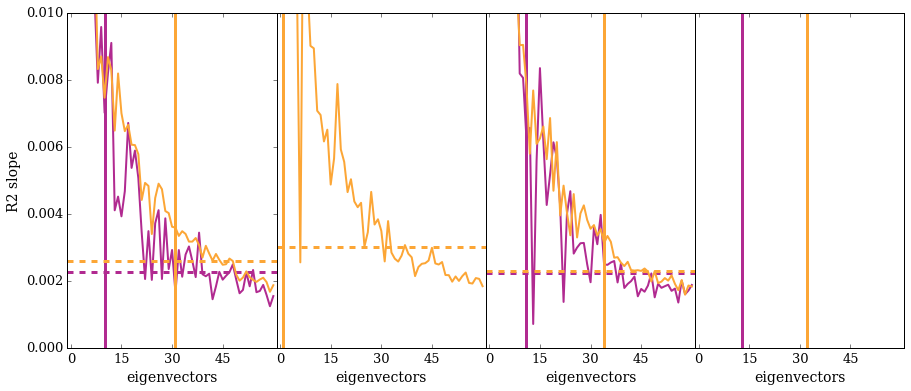

In [9]:
direcs = ['red_clump_12_TEFF_up4750.0_lo4700.0',
          'red_clump_12_TEFF_up4800.0_lo4750.0',
          'red_clump_12_TEFF_up4850.0_lo4800.0',
          'red_clump_12_TEFF_up4900.0_lo4850.0']
titles = ['',
          '',
          '',
          '']
models = ['eig60_minSNR50_corrNone_madFalse.pkl',
          'eig60_minSNR50_corrNone_madTrue.pkl',
          'eig60_minSNR50_corr30px_madFalse.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)','variance corrected']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename=None,figsize=(15,6))

In [10]:
rg50K = empca_residuals('apogee','red_clump',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 4800
Lower limit (Enter for minimum): 4750
Found good limits
Data key: done


Done getting filter information
Total 0 of 2235 stars missing


In [ ]:
direcs = [#'red_clump_12_TEFF_up4900.0_lo4700.0',
          'red_clump_12_TEFF_up4900.0_lo4700.0',
          'red_giant_12_TEFF_up4900.0_lo4700.0']
titles = [#'red_clump_12_TEFF_up4900.0_lo4700.0',
          '',
          '']
models = ['eig60_minSNR50_corrNone_madFalse.pkl',
          'eig60_minSNR50_corrNone_madTrue.pkl',
          'eig60_minSNR50_corr30px_madFalse.pkl']
labels = ['variance','median absolute\ndeviation (M.A.D.)','variance corrected']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename='RC_DR12_comparison.pdf',figsize=(15,6))

## Figure 13 - Ncells for red clump subsample comparison

## Figure 14 - R2 for red giant subsample comparison

#### To create the data for this figure, run the following in the same directory as this notebook

python run_all_empca.py

#### Then fill out the prompts with the bolded responses

Which sample: red clump, red giant or cluster? **red giant**  
How many eigenvectors in the model (Enter for 60): *press Enter*  
What's the minimum signal to noise? (Enter for 50): *press Enter*   
Shall I get data from scratch? (Enter for yes): **no**  
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **LOGG**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **3.0**  
Lower limit (Enter for minimum): **2.0**  
Found good limits 
Data key: **done** 

#### Then repeat this script once more, with all prompts the same except for the limits. The other other run should have 

Upper limit (Enter for maximum): **4.0**  
Lower limit (Enter for minimum): **3.0**  

#### This will take about four hours to complete for each run, so run in parallel if possible. Once it's done, run the box below

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



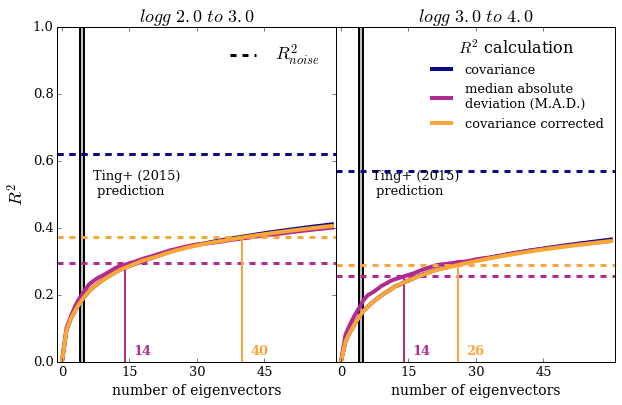

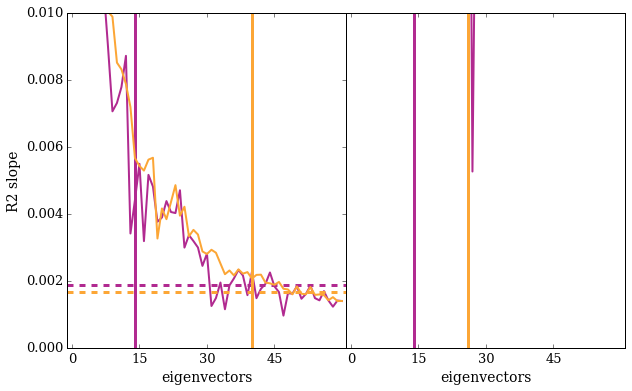

In [10]:
direcs = ['red_giant_12_LOGG_up3.0_lo2.0',
          'red_giant_12_LOGG_up4.0_lo3.0']
titles = [r'$logg\,\,2.0\,\,to\,\,3.0$',
          r'$logg\,\,3.0\,\,to\,\,4.0$',]
models = ['eig60_minSNR50_corrNone_madFalse.pkl',
          'eig60_minSNR50_corrNone_madTrue.pkl',
          'eig60_minSNR50_corr30px_madFalse.pkl']
labels = ['covariance','median absolute\ndeviation (M.A.D.)','covariance corrected']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename='RG_DR12_comparison.pdf',figsize=(10,6))

## Figure 15 - Ncells for red giant subsample comparison

## Figure 16 - Eigenvectors in M13

In [25]:
import apogee.spec.window as wn

elems = ['C','N','O','Na','Mg','Al','Si','S','K','Ca','Ti','V','Mn','Fe','Ni']

# Store information about where element windows are                                                                                         
# Track by element name                                                                                                                     
                                                                                                                                        
elemwindows = {}                                                                                                                            
# Track by array in order of periodic table                                                                                                 
normwindows = np.zeros((len(elems),aspcappix))
tfwindows = np.zeros((len(elems),aspcappix))
e = 0                                                                                                                                       
for elem in elems:                                                                                                                          
    w = wn.read(elem,dr=13,apStarWavegrid=False)                                                                                            
    nw = np.ma.masked_array(w/np.sqrt(np.sum(w)))                                                                                           
    elemwindows[elem] = w                                                                                                                   
    normwindows[e] = nw    
    tfwindows[e] = nw!=0
    e+=1                                                                                                                                    
tfwindows = tfwindows.astype(int)

In [46]:
def window_project(es):
    elemeigs = np.dot(es,normwindows.T)
    for e in elemeigs:
        e /= np.sqrt(np.sum(e**2))
    return elemeigs

In [47]:
def get_colors(n,cmap='plasma'):
    colors = plt.get_cmap(cmap)(np.linspace(0,0.90,n))
    fronthalf = colors[:np.ceil(n/2.)]
    backhalf = colors[np.ceil(n/2.):]
    colors = np.empty(colors.shape)
    colors[0::2] = fronthalf
    colors[1::2] = backhalf
    return colors

def plot_fullvec(model,n=5,pixup=7214,pixdown=0):
    colors = get_colors(n)
    plt.figure(figsize=(16,8))
    offset = 0
    for i in range(n):
        plt.axhline(offset,color='k',lw=1)
        plt.plot(np.arange(pixdown,pixup),model.eigvec[i][pixdown:pixup]+offset,lw=1,color=colors[i],label='eigenvector {0}'.format(i+1))
        offset+=0.08
    legend = plt.legend(loc='best',fontsize=15,ncol=5)
    legend.get_frame().set_linewidth(0.0)
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0)
    ylim=plt.ylim(-0.1,offset+0.1)
    xlim=plt.xlim(pixdown,pixup)
    
def plot_projvec(model,n=5,yup=0.15,ydown=-0.3):
    ws = window_project(model.eigvec[:n])
    colors = get_colors(n=n)
    plt.figure(figsize=(16,8))
    for w in range(len(ws)):
        plt.plot(ws[w],'o-',color=colors[w],lw=3,label='eigenvector {0}'.format(w+1),markersize=10,markeredgecolor='w')
    legend = plt.legend(loc='best',fontsize=20,ncol=2)
    legend.get_frame().set_linewidth(0.0)
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0)
    xtick = plt.xticks(np.arange(0,15),elems)
    ylim=plt.ylim(ydown,yup)

In [ ]:
m13 = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)

In [ ]:
m13.findResiduals(gen=False)

In [106]:
nvecs=5
minsnr=50
m13.pixelEMPCA(nvecs=nvecs,mad=True,
               savename='eig{0}_minSNR{1}_corrNone_madTrue.pkl'.format(nvecs,minsnr))

       iter        R2             rchi2
EMPCA  1/25      -0.03390200   2868.19958720
EMPCA  2/25      -5.30845959    158.38593952
EMPCA  3/25       0.61031826      4.77881452
EMPCA  4/25       0.81699920      2.15306666
EMPCA  5/25       0.83293391      1.93665585
EMPCA  6/25       0.83807467      1.85051727
EMPCA  7/25       0.84101782      1.81282146
EMPCA  8/25       0.84150798      1.80271632
EMPCA  9/25       0.84130066      1.80293385
EMPCA 10/25       0.84124487      1.80312593
EMPCA 11/25       0.84165161      1.79306738
EMPCA 12/25       0.84279043      1.78113490
EMPCA 13/25       0.84365551      1.77385988
EMPCA 14/25       0.84384971      1.76937211
EMPCA 15/25       0.84400638      1.76671046
EMPCA 16/25       0.84404856      1.76537209
EMPCA 17/25       0.84410137      1.76478379
EMPCA 18/25       0.84411693      1.76454931
EMPCA 19/25       0.84405151      1.76447130
EMPCA 20/25       0.84396480      1.76446215
EMPCA 21/25       0.84386352      1.76448276
EMPCA 22/25    

In [28]:
m13model = acs.pklread('clusters_12_CLUSTER_matchM13/eig5_minSNR50_corrNone_madTrue.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



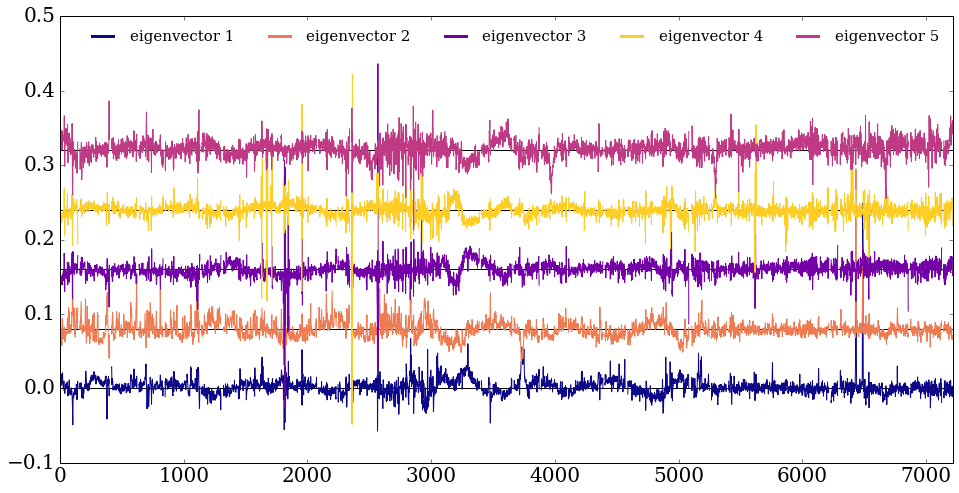

In [29]:
n=5
pixup = 7214
pixdown = 0
plot_fullvec(m13model,n=n,pixup=pixup,pixdown=pixdown)

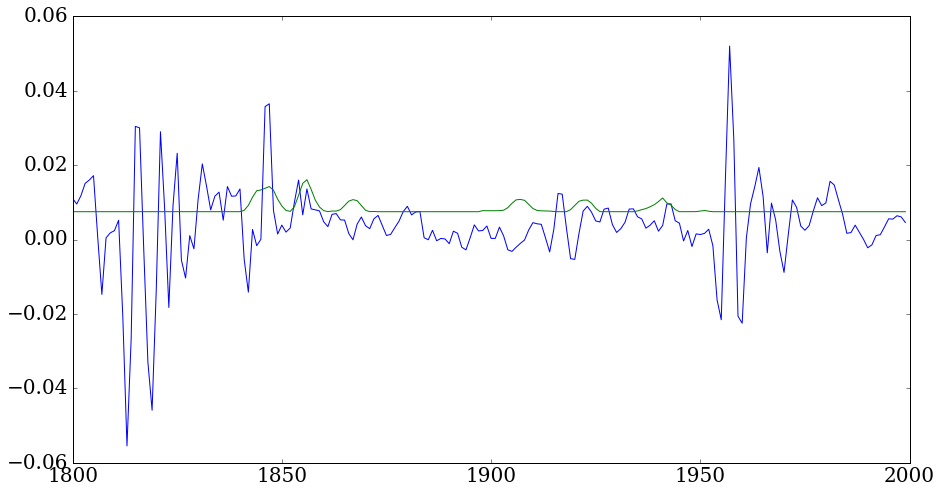

In [30]:
pixup=2000
pixdown = 1800
plt.figure(figsize=(15,8))
pixels = np.arange(0,7214)
plt.plot(pixels[pixdown:pixup],m13model.eigvec[0][pixdown:pixup])
plt.plot(pixels[pixdown:pixup],((np.sum(normwindows,axis=0)/15.)+0.0075)[pixdown:pixup])

In [31]:
m13model.eigvec[0][150]

masked

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



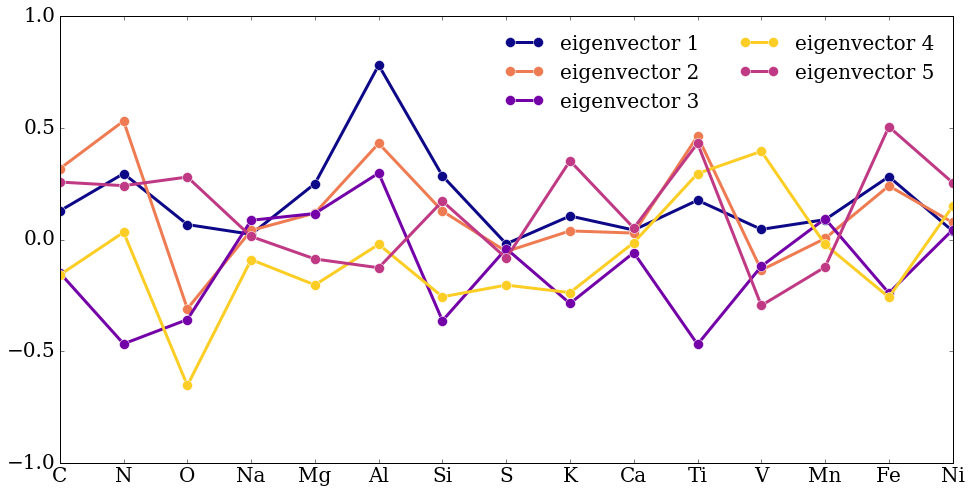

In [49]:
n=5
plot_projvec(m13model,n=n,yup=1,ydown=-1)

## Figure 17 - Eigenvectors in red clump

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



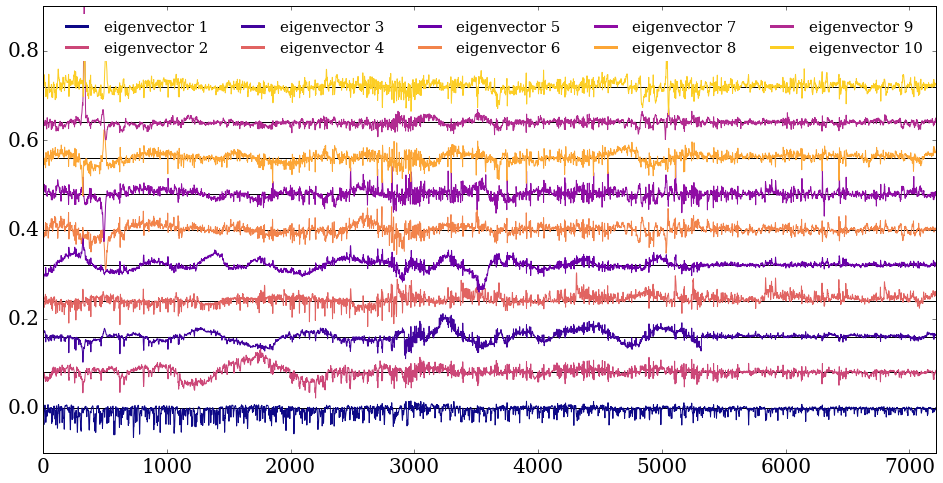

In [19]:
n=10
pixup = 7214
pixdown = 0
plot_fullvec(subrcmodel,n=n,pixup=pixup,pixdown=pixdown)

In [50]:
n=5
plot_projvec(subrcmodel,n=n,yup=1,ydown=-1)

NameError: name 'subrcmodel' is not defined

In [43]:
subrcmodel2 = acs.pklread('red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



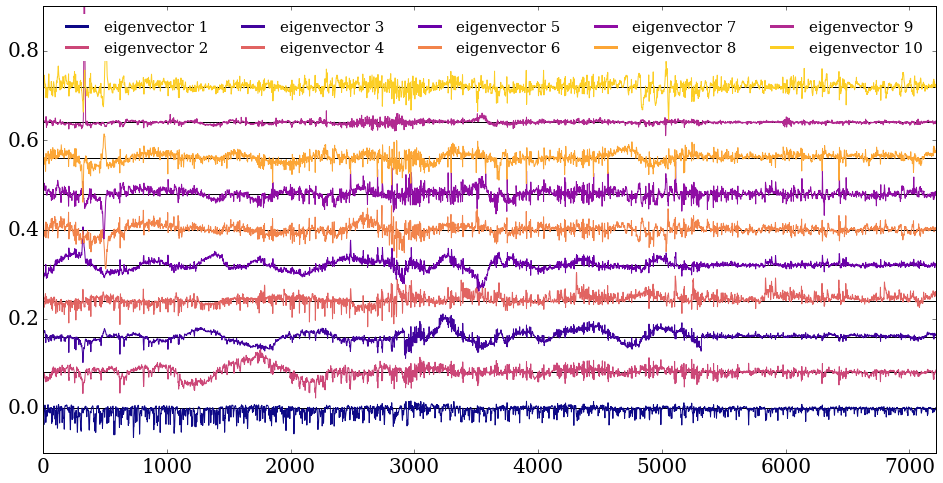

In [23]:
n=10
pixup = 7214
pixdown = 0
plot_fullvec(subrcmodel2,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



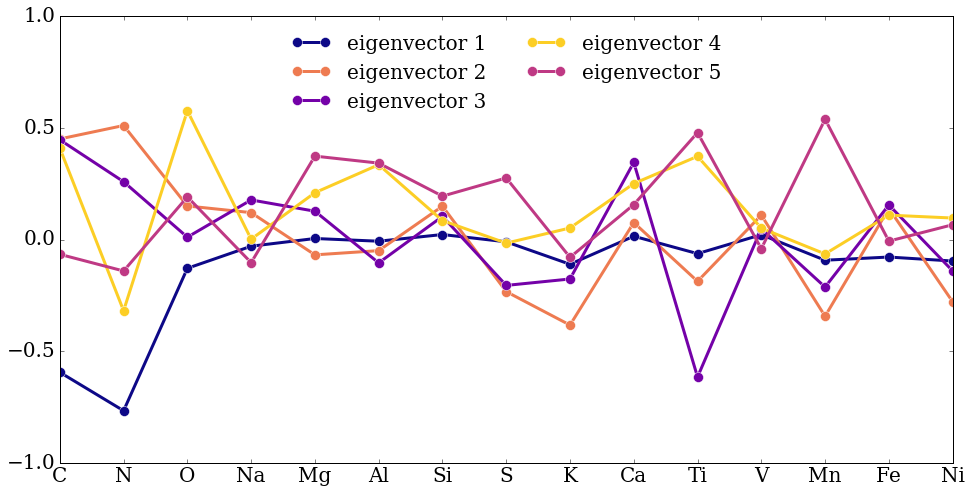

In [51]:
n=5
plot_projvec(subrcmodel2,n=n,yup=1,ydown=-1)

In [38]:
subrcmodelpersist = acs.pklread('red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue_persistMask.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



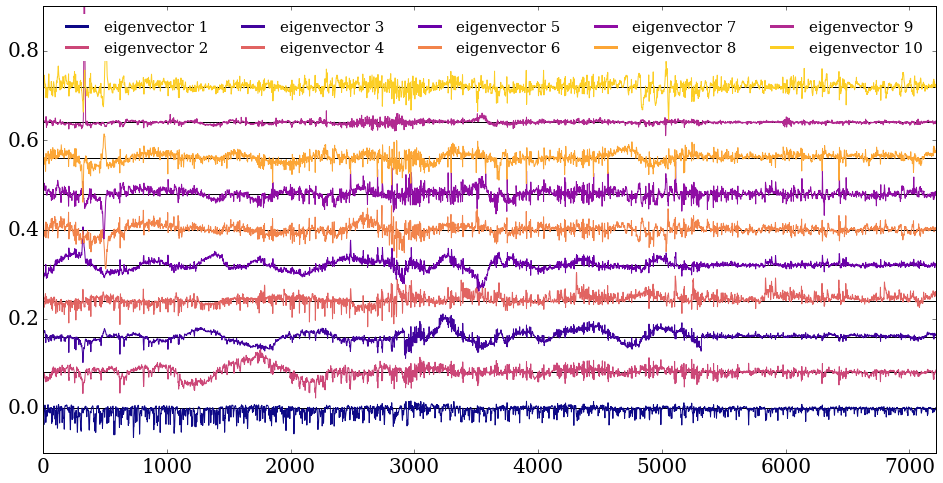

In [44]:
n=10
pixup = 7214
pixdown = 0
plot_fullvec(subrcmodel2,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



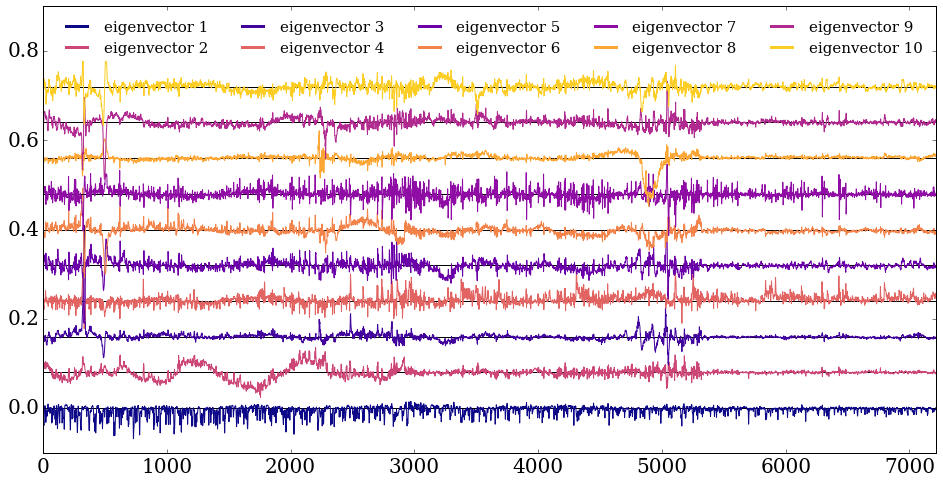

In [40]:
n=10
pixup = 7214
pixdown = 0
plot_fullvec(subrcmodelpersist,n=n,pixup=pixup,pixdown=pixdown)

In [54]:
subrcmodelpersist.R2noise,subrcmodelpersist.R2Array

(0.15369397839122179,
 array([ 0.        ,  0.07846916,  0.10337536,  0.10540028,  0.1275976 ,
         0.13882634,  0.14834902,  0.16256072,  0.16761877,  0.17433973,
         0.1843062 ,  0.19177932,  0.19783673,  0.2046163 ,  0.21256544,
         0.21458503,  0.21603075,  0.2211624 ,  0.2245781 ,  0.22900019,
         0.23423242,  0.23829042,  0.24406974,  0.24846773,  0.25151156,
         0.25697239,  0.26046586,  0.26511768,  0.26971976,  0.27402559,
         0.27550778,  0.27827196,  0.28233734,  0.28597498,  0.2877053 ,
         0.29070853,  0.2922284 ,  0.29503771,  0.29841276,  0.30100438,
         0.30393622,  0.30766207,  0.30982236,  0.31217925,  0.31402933,
         0.31704621,  0.31959408,  0.3220029 ,  0.32411246,  0.32702343,
         0.32962212,  0.33193965,  0.33423947,  0.33658165,  0.33848252,
         0.34070902,  0.34301975,  0.34520532,  0.3473529 ,  0.34939263,
         0.35155024]))

In [55]:
subrcmodel2.R2noise,subrcmodel2.R2Array

(0.25596251746662801,
 array([ 0.        ,  0.08034587,  0.1188075 ,  0.14640951,  0.1707814 ,
         0.1798444 ,  0.19273859,  0.20647257,  0.21919288,  0.22294861,
         0.23336455,  0.23999077,  0.24495685,  0.25293946,  0.26071341,
         0.26574558,  0.27194406,  0.27868967,  0.28370093,  0.28922715,
         0.29090902,  0.29515609,  0.29746877,  0.30241583,  0.3057118 ,
         0.31070454,  0.31347246,  0.31626851,  0.31875152,  0.32260209,
         0.32634186,  0.32975271,  0.33120739,  0.33457043,  0.33847055,
         0.34013991,  0.3425992 ,  0.34569157,  0.34820189,  0.35049124,
         0.35223624,  0.35404379,  0.35614691,  0.35811726,  0.35955677,
         0.36166056,  0.36334723,  0.36530603,  0.36651053,  0.36809111,
         0.36983528,  0.37158175,  0.37350582,  0.37519937,  0.37736666,
         0.37908767,  0.38060996,  0.38211467,  0.38369386,  0.38562384,
         0.38712957]))

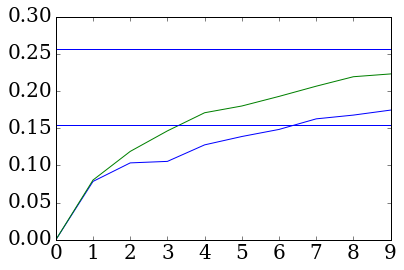

In [60]:
plt.plot(subrcmodelpersist.R2Array[:14])
plt.plot(subrcmodel2.R2Array[:14])
plt.axhline(subrcmodelpersist.R2noise)
plt.axhline(subrcmodel2.R2noise)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



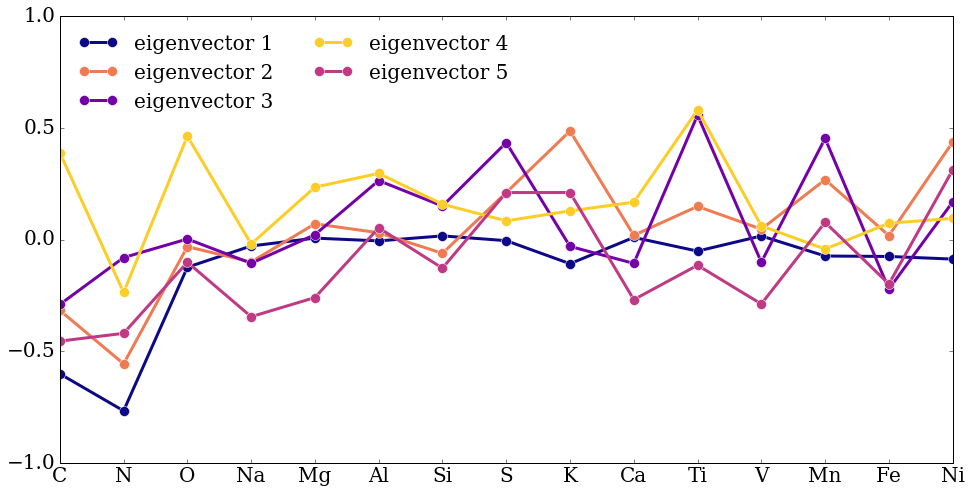

In [53]:
n=5
plot_projvec(subrcmodelpersist,n=n,yup=1,ydown=-1)

In [25]:
subrcmodel3 = acs.pklread('red_clump_12_TEFF_up4900.0_lo4700.0/eig60_minSNR50_corrNone_madTrue.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



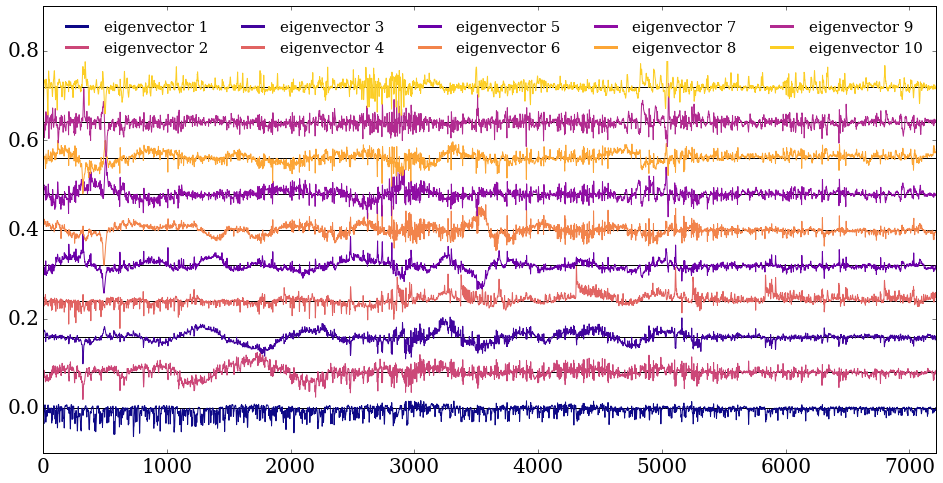

In [26]:
n=10
pixup = 7214
pixdown = 0
plot_fullvec(subrcmodel3,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



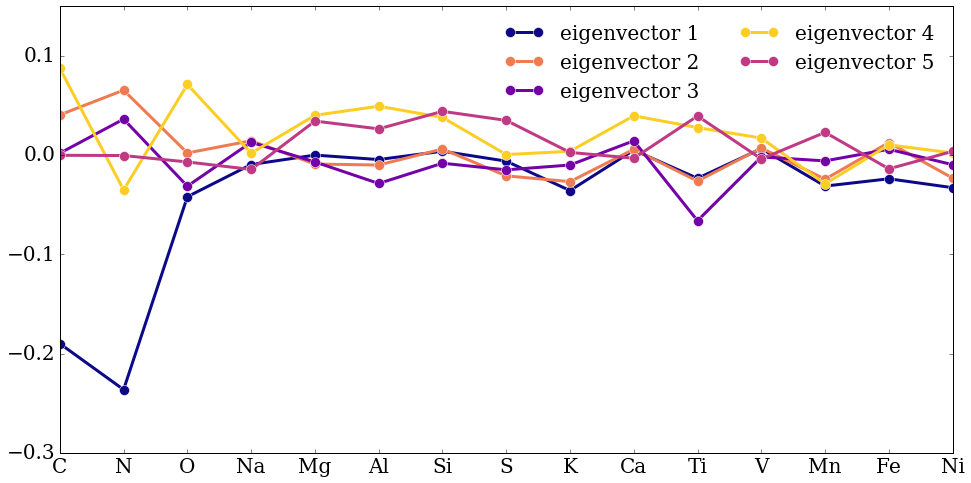

In [27]:
n=5
plot_projvec(subrcmodel3,n=n,yup=0.15,ydown=-0.3)

## Figure 18 - Eigenvectors in N6819

In [28]:
n6819 = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: CLUSTER
Default is full range. Match or slice? m
Match value: N6819
Data key: done
Done getting filter information


In [29]:
n6819.findResiduals()

In [157]:
nvecs=5
minsnr=50
n6819.pixelEMPCA(nvecs=nvecs,mad=True,
                 savename='eig{0}_minSNR{1}_corrNone_madTrue.pkl'.format(nvecs,minsnr))

       iter        R2             rchi2
EMPCA  1/25       0.01100167    200.77387855
EMPCA  2/25       0.28572340      2.07160787
EMPCA  3/25       0.45504732      1.58567853
EMPCA  4/25       0.47367056      1.51850395
EMPCA  5/25       0.56234879      1.18011551
EMPCA  6/25       0.57384536      1.14520301
EMPCA  7/25       0.57792541      1.13070889
EMPCA  8/25       0.57818488      1.12533080
EMPCA  9/25       0.57813966      1.12343188
EMPCA 10/25       0.57840615      1.12264886
EMPCA 11/25       0.57805376      1.12219709
EMPCA 12/25       0.57866593      1.12193461
EMPCA 13/25       0.57881465      1.12194537
EMPCA 14/25       0.57896203      1.12224325
EMPCA 15/25       0.57925629      1.12243177
EMPCA 16/25       0.57969510      1.12217260
EMPCA 17/25       0.57960528      1.12150619
EMPCA 18/25       0.57998576      1.12069089
EMPCA 19/25       0.58053357      1.11999765
EMPCA 20/25       0.58091904      1.11954977
EMPCA 21/25       0.58099083      1.11930466
EMPCA 22/25    

In [35]:
n6819model = acs.pklread('clusters_12_CLUSTER_matchN6819/eig5_minSNR50_corrNone_madTrue.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



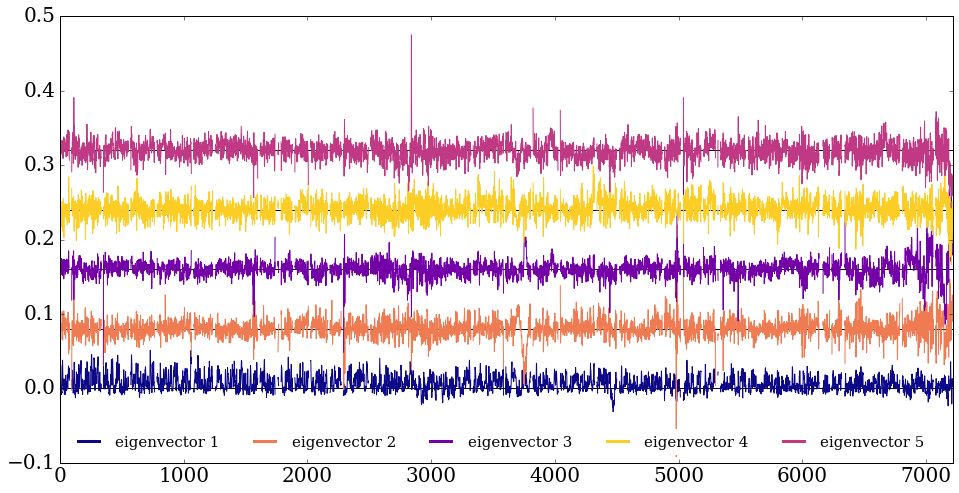

In [36]:
n=5
pixup = 7214
pixdown = 0
plot_fullvec(n6819model,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



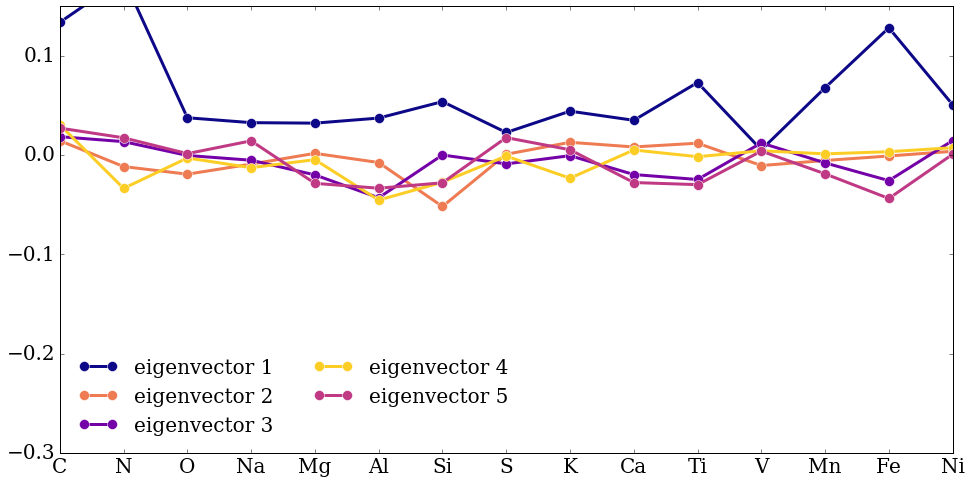

In [37]:
n=5
plot_projvec(n6819model,n=n,yup=0.15,ydown=-0.3)